# Advanced Scikit-learn

## Modular preprocessing and pipelines

### Modular pipelines

* Data science processes can be organized as a sequence of modular steps
* Modularity is about mutual independence of the components in a project
* Modularity is desirable because it helps with:
    * Coding design, parallel development, optimization, performance comparisons, re-usability...
* We will look into the modular implementation of modeling with scikit-learn

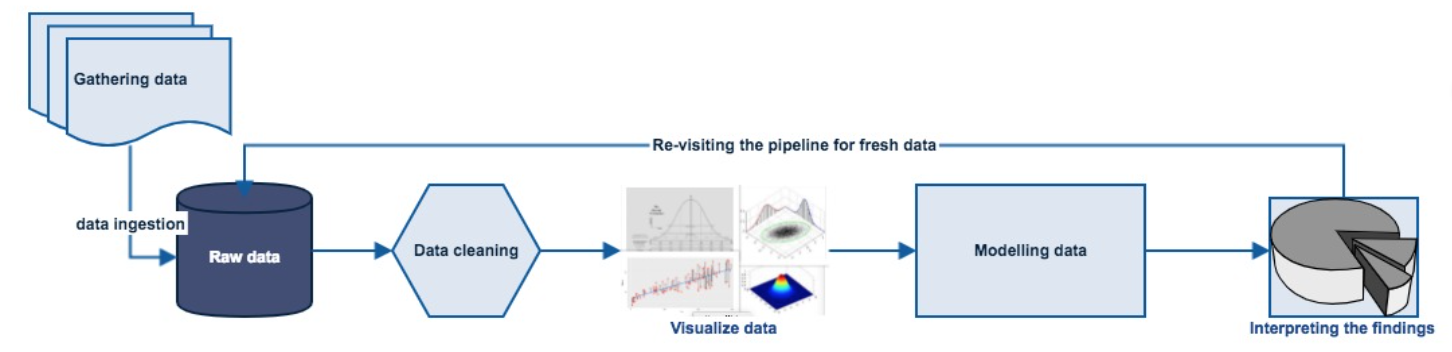

Data science projects have multiple steps, from gathering data, cleaning it, modeling, and to visualizing final results. This sequence of steps indicates a modularity in the process.

Modularity is is about mutual independence of the components in a project. In any project, modularity is a desirable property. This independence permits different parts to be developed and improved in parallel.

In coding projects, modularity permits well-designed architectures, where we can implement, optimize, test and update different part of the process separately, while at the same time have the parts integrated in a single architecture through their interfaces. In this lesson we will look into the modeling process, and how we can implement modularity there.

### Modeling pipeline

* The modeling process can be divided into some well-defined parts:
    * Data splitting, preprocessing, fitting, prediction, evaluation
* Scikit-learn provides tools to work with these steps as a pipeline:
    * Convenience functions (e.g. `cross_val_score()`)
    * Pipeline libraries (e.g. `Transformer`, `Pipeline`)
* We will learn how to use `Transformer`s, `Pipeline`s and other useful modules

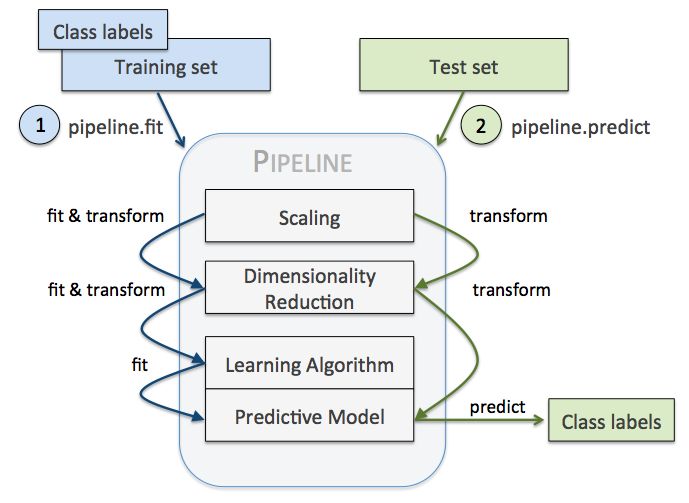

The modeling process can be divided into some well-defined parts. They usually include splitting the data into train and test, preprocessing the data, training the model, making predictions, and evaluating the model outputs.

Scikit-learn provides useful libraries to build this pipeline. In some cases, this is achieved by providing easy-to-use convenience functions (e.g. `cross_val_score` includes data splitting, prediction and evaluation), but it also includes modules that allow you to build your own modular pipelines.

We will go through some of these tools in this lesson.

### Scikit-learn pipeline

* Scikit-learn `Pipeline` allows you put together modeling building blocks
* Each building block is an `Estimator`, `Transformer` or `Pipeline`

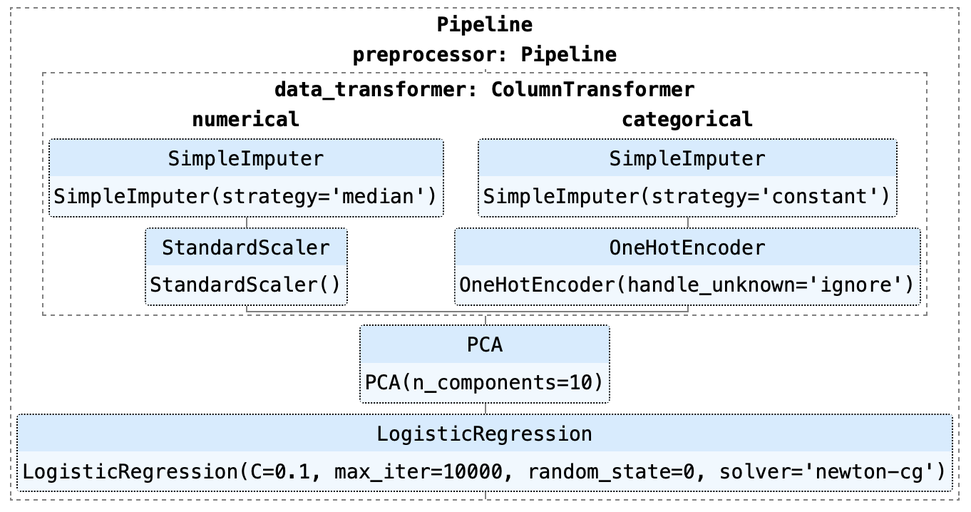

Here you see an example of a scikit-learn `Pipeline` design. With it you can include building blocks of transformations in a flow chart. Here first the data is preprocessed, its dimensionality is then reduced with PCA, before a Logistic regression model is trained on these features. 

Each building block is an `Estimator`, `Transformer` or `Pipeline`. `Estimator`s are the well-known models, which are trained to make predictions. Transformers are preprocessing steps that transform your data, e.g. scaling.

The modular structure allows a building block itself to be a `Pipeline`, with multiple steps, as is the case for the preprocessor block here. It also allows different branches to be processed differently and then joined.

We will first learn more about preprocessing with `Transformer`s.

### Preprocessing steps

* There are many preprocessing steps:
    * **Drop** unwanted features
    * **Impute** missing values
    * **Hand-engineer** features
    * **One-hot** encoding
    * **Scale** features 
    * **Reduce** dimensionality
* They are applied sometimes in sequence, sometimes in parallel (e.g. categorical or numerical features)

Preprocessing means transforming your data to be a suitable input for your algorithm.

There are many necessary steps, such as dealing with missing values, selecting features and transforming categorical variables.

Some processes are optional and will require some intuition or experience for knowing when to use them, such as reducing dimensionality or hand-engineering features.

As we will see, some of these make sense to be performed in sequence (imputation before scaling), while others make sense to be performed in parallel (different processes for categorical and numerical features).

### Transformer functions

* Scikit-learn modules:
    * **Drop** unwanted features -> `ColumnTransformer`
    * **Imputation** of missing values -> `SimpleImputer`
    * **Hand-engineer** features -> `FunctionTransformer`
    * **One-hot** encoding -> `OneHotEncoder`
    * **Scale** features -> `StandardScaler`
    * **Reduce** dimensionality -> `PCA`

Scikit-learn `Transformer`s are a family of classes that perform preprocessing functions. They are designed to be put together as building blocks in a preprocessing pipeline. Let's see an example.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer, PolynomialFeatures, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import TransformerMixin, BaseEstimator

np.set_printoptions(precision=2)

### Example: Normalization

In [3]:
data = pd.read_csv("data/SeoulBikeData.csv")
X = data[["Hour", "Temperature(°C)", "Wind speed (m/s)", "Holiday", "Seasons"]]
y = data["Rented Bike Count"];
X_train, X_test, y_train, y_test = train_test_split(X, y);
split = ShuffleSplit(n_splits=1)

In [4]:
X.head(3)

,Hour,Temperature(°C),Wind speed (m/s),Holiday,Seasons
0,0,-5.2,2.2,No Holiday,Winter
1,1,-5.5,0.8,No Holiday,Winter
2,2,-6.0,1.0,No Holiday,Winter


In [21]:
preprocessor = StandardScaler() # Instantiate the scaler

preprocessor.fit(X_train[["Hour"]])  # Calculates scaling factors

X_pp = preprocessor.transform(X_train[["Hour"]])
print(X_pp[:3])

[[ 1.36]
 [-1.24]
 [ 0.63]]


This is a dataset for predicting bike rentals in Seoul based on data such as the weather. We see there are five features that we will consider. Some are numerical and some are categorical.

An example of a `Transformer` is to normalize a numerical variable, here `Hour`, to zero mean and unit standard deviation. The `Transformer` has two main steps.

`.fit()` uses training data to calculate the necessary factors (in this case the mean and standard deviation of the feature).

Once fitted, it can be applied with `.transform()`, returning the transformed feature.

### Processing categorical and numerical features

In [22]:
cat_cols = ["Holiday", "Seasons"]
num_cols = ["Hour", "Temperature(°C)", "Wind speed (m/s)"]

# column transformer -- list of tuples --

# Selects columns and joins
column_preprocessor = ColumnTransformer([
    ("normalize", StandardScaler(), num_cols),
    ("onehot", OneHotEncoder(sparse_output=False), cat_cols)
])

column_preprocessor.fit(X_train)  # Calculates scaling factors and categories

X_pp1 = column_preprocessor.transform(X_train)
print(X_pp1[:2,:])

[[ 1.36  1.52 -0.03  0.    1.    0.    0.    1.    0.  ]
 [-1.24  1.35 -1.19  0.    1.    0.    0.    1.    0.  ]]


### Processing categorical and numerical features

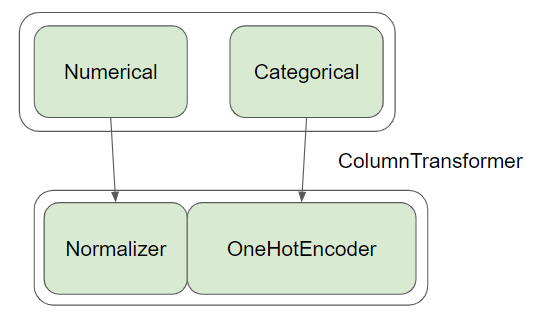

Going one step further, we can simultaneously handle both numerical and categorical features. 

This pipeline will normalize the numerical columns, while also performing a one-hot encoding on the categorical columns.

The `ColumnTransformer` allows us to select some columns of the input data, perform different transformations on them, before finally joining the results.

Again, `.fit()` will calculate the necessary parameters for the transformations; in this case, mean and variance for the normalization, and the list of categories for the one-hot encoder.

The resulting matrix has 9 columns, 3 from the 3 numerical features, and 6 from the 6 categories (holiday, not holiday, and the four seasons).

### Data leakage and reusability

Once the `Transformer` is created, it can be applied to other data sets:

In [23]:
column_preprocessor.fit(X_train)
column_preprocessor.transform(X_train)
column_preprocessor.transform(X_test)
column_preprocessor.transform(X[4:6]);

The separation of fitting the preprocessor on *only* the training data ensures that there is no **data leakage** from the test set.

Data leakage is when information from outside the training dataset is used to create the model.

The separation of the `.fit()` and `.transform()` methods makes it easy to separate training and testing phases. By using only training data during the fit, it makes sure there is no data leakage from the test set (that is your training procedure doesn't use any information from the test set). Once fitted, the transformer can be applied to any new data.

### Hand-engineered features

In [25]:
X_pp1.shape

(6570, 9)

In [24]:
# Joins two Transformers in parallel

# list of tuples- applying both transformations and then combine it together

#label: function being performed

handcraft_transformer = FeatureUnion([('Squared', FunctionTransformer(np.square)),
                                      ('PCA',  PCA(n_components=3))])
# pca: 0-1: 0.8 --80% of variance of the data, or float for number of components we'd like to keep
X_pp2 = handcraft_transformer.fit_transform(X_pp1)
X_pp2.shape 

(6570, 12)

### Hand-engineered features

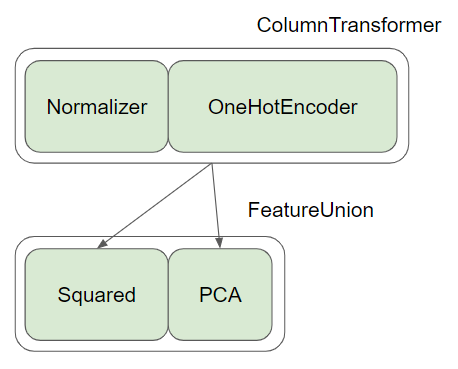

Once your features are in a proper numerical format, you may want to do more fancy transformations to create new features.

Here we create a hand-crafted feature that is the square of the original feature. We also do dimensionality reduction with PCA, which can be useful when there are many features.

The `FeatureUnion` transformer will join the resulting features into a single matrix, just as the `ColumnTransformer` did. There are 12 resulting features, 9 for the squared features, and 3 for the PCA dimensions that we have retained.

### Custom Transformers

* Inherit from `TransformerMixin` and `BaseEstimators` classes
* Implement `.fit()` that memorizes necessary properties from training data 
* Implement `.transform()` which applies the actual transformation

In [26]:
# base clases in sckikit learn in order to have a fit transform methods - base estimator allows you to access the parameters

# allows us to fit / transform methods
class ExtremeValues(TransformerMixin, BaseEstimator):
    
    def fit(self, X, y= None):
        self.extreme_above = np.quantile(X, 0.95, axis= 0)
        self.extreme_below = np.quantile(X, 0.05, axis= 0)
        return self

    def transform(self, X, y= None):
        return (X > self.extreme_above) | (X < self.extreme_below)

extreme = ExtremeValues().fit(X_train["Temperature(°C)"])

print("Temperature thresholds: ", extreme.extreme_below,  extreme.extreme_above)
print("Input: ", X_test["Temperature(°C)"][:10].values)
print("Is it extreme?: ",  extreme.transform(X_test["Temperature(°C)"][:10].values))

Temperature thresholds:  -7.0 31.0
Input:  [ 8.8 -4.6 25.6 26.1 15.5 23.9  4.3 -3.2 23.8 17.9]
Is it extreme?:  [False False False False False False False False False False]


While there are plenty of ready-to-use transformers, you may want to create your own non-standard transformations. For example, we may want to add a feature that detects extreme values of a feature. 

Here is an example of a custom feature. You create a class with this template, and create the `.fit()` and `.transform()` methods. In the `.fit()` method you calculate the necessary parameters of your transformation. For the extreme sample detection, we calculate the 5% and 95% percentiles of the feature, which will be used as thresholds for detection. 

In the `.transform()` method we apply the actual transformation, here checking if the feature value is outside the threshold range.

Here we see how it is applied to the `Temperature` feature. We fit it, calculating the thresholds, which are -7 degrees, and +30 degrees Celsius, which makes sense. Then we apply it to some test data, and we see that only the day where the temperature was -9.1 degrees returns `True`.

### Pipeline

* `Pipeline` builds sequences of `Transformer`s

In [11]:
# Instantiate as a list of tuples

scaled_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
])

scaled_pca.fit(X_pp1)         # fits both steps
scaled_pca.transform(X_pp1);  # applies both steps

### Pipeline

* `Pipeline`s builds sequences of `Transformer`s

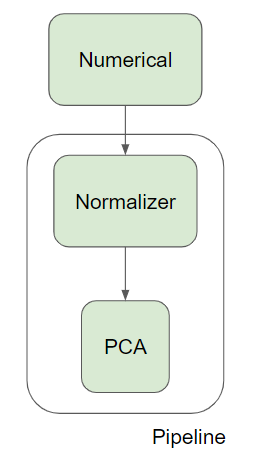

In this schema, the `Transformer`s manipulate our data, while the `Pipeline` puts these transformations together in a sequence. In fact, the `Pipeline` is actually a type of `Transformer`, which joins individual `Transformer`s in a sequence.

For example, we may want to normalize our features before doing PCA, as is done here.

### Complete pipeline

* Construct a flow of transformations, with a prediction model at the end
* Separation of data handling and processing
* Reusable, easier to test and maintain 

### Complete pipeline

In [27]:
column_preprocessor = ColumnTransformer([
    ("normalize", StandardScaler(), num_cols),
    ("onehot", OneHotEncoder(sparse_output=False), cat_cols)
])

scaled_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
])

handcraft_transformer = FeatureUnion([
    ("Squared", FunctionTransformer(np.square)),
    ("ScaledPCA", scaled_pca)
])

full_pipeline = Pipeline([
    ("pp_1", column_preprocessor),
    ("pp_2", handcraft_transformer),
    ("model", LinearRegression())
])

cross_val_score(full_pipeline, X, y, cv=split)

array([0.41])

### Complete pipeline

* Construct a flow of transformations, with a prediction model at the end
* Separation of data handling and processing
* Reusable, easier to test and maintain 

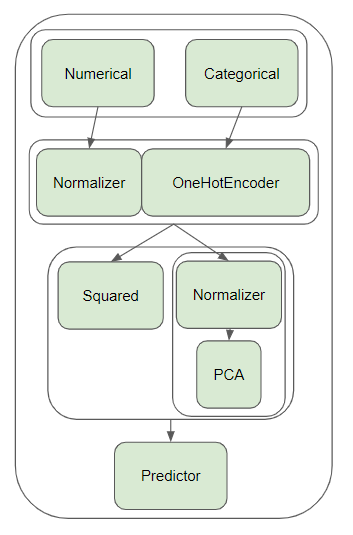

Now we have all the ingredients to build a full pipeline. We have the individual building blocks, which are put together either in parallel by a `ColumnTransformer` or a `FeatureUnion`, or in sequence by a `Pipeline`.

And in the end of the preprocessing pipeline we add the desired predictor, here a Linear regression module. Pipelines can include predictors too, calling their `.predict()` method when `.transform()` is called.

In a few lines we have a fancy setup that can be easily reused, optimized and updated.

### Hyper-parameter optimization 

* Easy to optimize hyper-parameters of your model
* Can optimize preprocessing and prediction parameters jointly

In [29]:
params = {'pp_2__ScaledPCA__pca__n_components': range(1, 6)}

gcv = GridSearchCV(full_pipeline, param_grid=params, n_jobs=-1, cv=split)
gcv.fit(X_train, y_train);

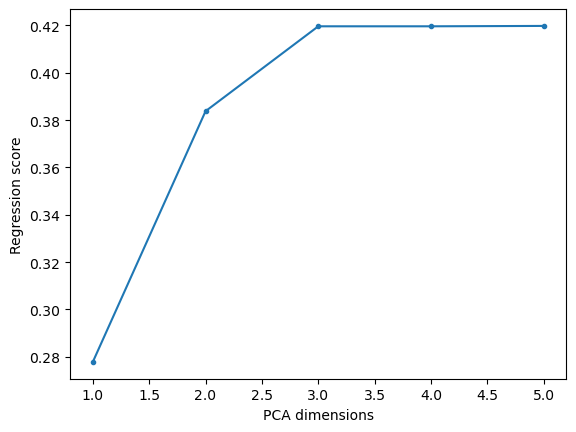

In [14]:
#plt.figure(figsize=(4, 3))
plt.plot(range(1, 6), gcv.cv_results_["mean_test_score"], '.-');
plt.xlabel("PCA dimensions")
plt.ylabel("Regression score");

Now that your whole pipeline is in a single object, you can use it with ease.

One fancy thing we can do is hyper-parameter optimization. We can for example use grid search, which will test different hyper-parameters of your model, including both model and preprocessing parameters. Here we look into the PCA hyper-parameter: that is, the number of PCA dimensions we retain. We can see from the plot that 3 dimensions seems to be the optimal value.

You can also optimize multiple parameters at once, from both preprocessing and the predictor, as they are now a single pipeline model.

### Storage of pre-trained models

* Store pre-trained model
* Store full-pipeline object

In [30]:
full_pipeline.set_params(**gcv.best_params_);
full_pipeline.fit(X_train, y_train);

## Store

In [31]:
# open a path, and make a name, wb means write-binary -- efficient storage method for files in python
with open("data/pretrained_model.pickle", "wb") as f:
    pickle.dump(full_pipeline, f)

## Retrieve

In [36]:
# rb = read-binary
with open("data/pretrained_model.pickle", "rb") as f:
    pretrained_model = pickle.load(f)
    
y_pred = pretrained_model.predict(X_test)

one of the issues with Pickle is that the saved dependencies of the versions we're using -- we can run into issues
so need to specify libraries and versions of the library

We can use the `pickle` library to save the best pre-trained model for later use! As we now have the full pipeline in a single object, it is very easy to reuse later.

Pickle is a great library for saving trained models, but keep in mind that it does not save dependencies. To be able to load your model, you need to import the code it relies on: external libraries and our own class definitions. Because of this, it is common to get errors when trying to load a model trained with an old version of a library. Take care!

### Reproducible experiments

* Requirements for reproducibility: same code, data and random seed

In [33]:
small_data = data.sample(200, axis=0)
X_small = small_data[["Hour", "Temperature(°C)", "Wind speed (m/s)", "Holiday", "Seasons"]]
y_small = small_data["Rented Bike Count"];

In [34]:
print(X_small.shape)

(200, 5)


In [35]:
np.random.seed(); print(cross_val_score(full_pipeline, X_small, y_small, cv=split))
np.random.seed(); print(cross_val_score(full_pipeline, X_small, y_small, cv=split))

np.random.seed(13579); print(cross_val_score(full_pipeline, X_small, y_small, cv=split))
np.random.seed(13579); print(cross_val_score(full_pipeline, X_small, y_small, cv=split))

[0.48]
[0.33]
[0.38]
[0.38]


We can also experiment with how reliable our results are. For example, in cases where the model is complex, or the data sample size is small, or the training procedure is noisy; the results may change a lot between training trials.

To make sure your model was not just lucky to get good results for a given training session, it is important to know how to make reproducible experiments. Apart from having the same code and data, to be reproducible, one needs to have same random number generator state.

Here we have the same data as before, but with only 200 samples. When we run our pipeline, we see very different results for each trial, depending on how the train/test split occurs. However, when we fix the random seed before running, it will have the same result.

## Jupyter-exercise

Advanced Scikit-learn

Open file `advanced-sklearn-practical.ipynb`